C:\Users\EL0021\AppData\Local\Temp\ipykernel_9468\1299092714.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Model"] = model  # 모델 이름 추가
C:\Users\EL0021\AppData\Local\Temp\ipykernel_9468\1299092714.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Model"] = model  # 모델 이름 추가
C:\Users\EL0021\AppData\Local\Temp\ipykernel_9468\1299092714.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

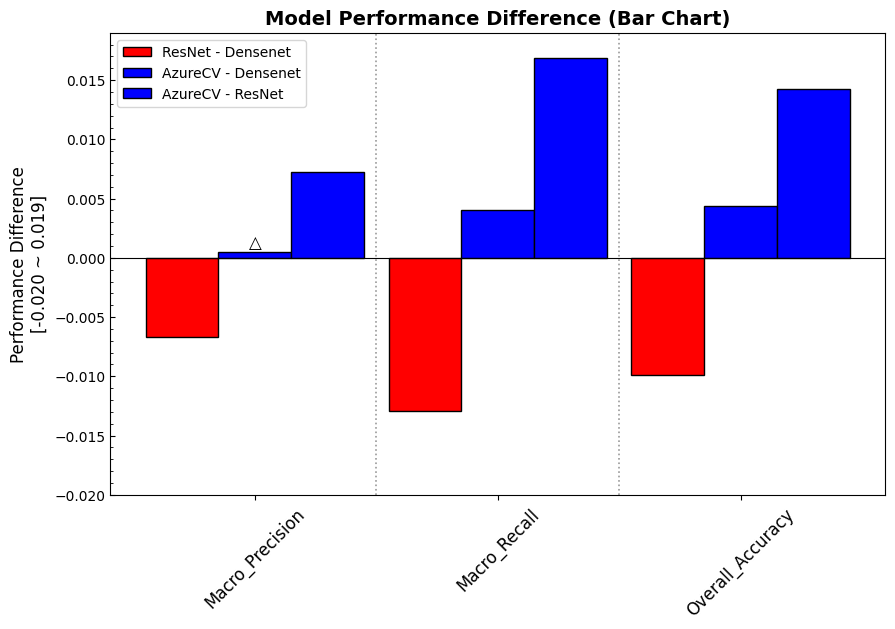

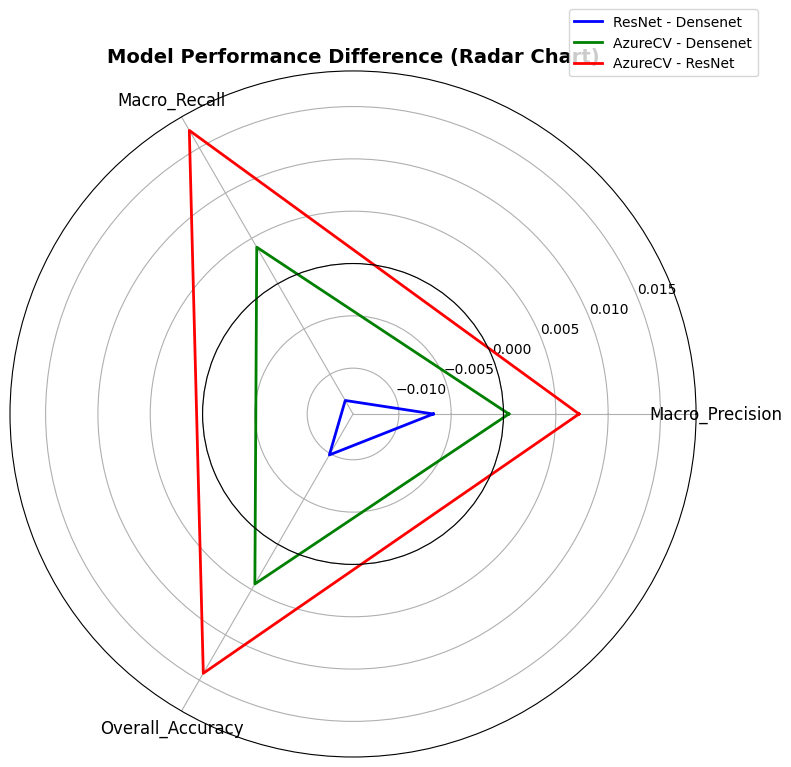

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 📌 파일 경로 설정
files = {
    "Densenet": r"C:\Users\EL0021\Desktop\평가서\3-2\metric\densenet.tsv",
    "ResNet": r"C:\Users\EL0021\Desktop\평가서\3-2\metric\resnet18.tsv",
    "AzureCV": r"C:\Users\EL0021\Desktop\평가서\3-2\metric\ACV.tsv"
}

# 📌 데이터 불러오기
dfs = {model: pd.read_csv(path, sep="\t") for model, path in files.items()}

# 📌 필요한 metric만 필터링
selected_metrics = ["Macro_Precision", "Macro_Recall", "Overall_Accuracy"]
df_combined = pd.DataFrame()

for model, df in dfs.items():
    df = df[df["metric"].isin(selected_metrics)]  # 필요한 metric만 선택
    df["Model"] = model  # 모델 이름 추가
    df_combined = pd.concat([df_combined, df])

# 📌 Pivot 테이블 변환 (행: metric, 열: 모델, 값: value)
df_pivot = df_combined.pivot(index="metric", columns="Model", values="value")

# 📌 차이 계산 (Densenet 기준)
df_diff = pd.DataFrame()
df_diff["ResNet - Densenet"] = df_pivot["ResNet"] - df_pivot["Densenet"]
df_diff["AzureCV - Densenet"] = df_pivot["AzureCV"] - df_pivot["Densenet"]
df_diff["AzureCV - ResNet"] = df_pivot["AzureCV"] - df_pivot["ResNet"]

# ✅ 색상 구분 함수 (양수: 파랑, 음수: 빨강)
def get_colors(values):
    return ["blue" if v >= 0 else "red" for v in values]

# 🌟 1️⃣ 막대 그래프 (차이 값)
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
x = np.arange(len(df_diff.index))

bars1 = ax.bar(x - bar_width, df_diff["ResNet - Densenet"], width=bar_width, 
               label="ResNet - Densenet", color=get_colors(df_diff["ResNet - Densenet"]), edgecolor="black")
bars2 = ax.bar(x, df_diff["AzureCV - Densenet"], width=bar_width, 
               label="AzureCV - Densenet", color=get_colors(df_diff["AzureCV - Densenet"]), edgecolor="black")
bars3 = ax.bar(x + bar_width, df_diff["AzureCV - ResNet"], width=bar_width, 
               label="AzureCV - ResNet", color=get_colors(df_diff["AzureCV - ResNet"]), edgecolor="black")

# ✅ x축 설정
ax.set_xticks(x)
ax.set_xticklabels(df_diff.index, rotation=45, fontsize=12)

# ✅ y축 간격 설정 (주눈금 5개, 0.005 간격)
major_ticks = np.arange(-0.02, 0.02, 0.005)  
ax.set_yticks(major_ticks)


# ✅ 보조 눈금 추가 (각 간격 사이 0.001 단위 5개)
minor_ticks = np.arange(-0.02, 0.02, 0.001)  
ax.set_yticks(minor_ticks, minor=True)

# ✅ y축 눈금을 차트 내부로 이동
ax.tick_params(axis='y', direction='in', which='both')

# ✅ 막대 그래프의 y축 범위 저장
y_min, y_max = ax.get_ylim()

# ✅ 0 기준선 추가
ax.axhline(0, color='black', linewidth=0.8)

# 📌 특정 기호 표시 (차이가 작은 값 & 0)
threshold = 0.001  # 차이가 매우 작은 값 기준
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) < threshold or height == 0:
            symbol = "△" if height > 0 else "▽" if height < 0 else "━"
            ax.text(bar.get_x() + bar.get_width()/2, height * 1.05, symbol, 
                    ha='center', va='bottom', fontsize=12, fontweight="bold")

# ✅ 칼럼 간 구분을 위한 점선 추가
for i in range(1, len(df_diff.index)):
    ax.axvline(i - 0.5, color='gray', linestyle='dotted', alpha=0.8, linewidth=1.2, zorder=3)

# ✅ 제목 & 범례 추가
ax.set_ylabel("Performance Difference", fontsize=12)
ax.set_title("Model Performance Difference (Bar Chart)", fontsize=14, fontweight="bold")
# ✅ y축 라벨에도 범위 추가 가능 (선택 사항)
ax.set_ylabel(f"Performance Difference\n[{y_min:.3f} ~ {y_max:.3f}]", fontsize=12)

ax.legend()

plt.show()  # 막대 그래프 출력

# 🌟 2️⃣ 레이더 차트 (차이 값만 표시)
labels = df_diff.index
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # 원형으로 만들기 위해 처음 값 추가

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})
colors = {"ResNet - Densenet": "blue", "AzureCV - Densenet": "green", "AzureCV - ResNet": "red"}

for diff_col in df_diff.columns:
    values = df_diff[diff_col].tolist()
    values += values[:1]  # 원형 그래프를 닫기 위해 첫 번째 값 추가
    ax.plot(angles, values, linestyle="-", color=colors[diff_col], linewidth=2, label=diff_col)


# ✅ 각 축의 레이블 추가
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# ✅ 0 기준선 추가
ax.axhline(0, color='black', linewidth=0.8)

# ✅ 제목 & 범례 추가
ax.set_title("Model Performance Difference (Radar Chart)", fontsize=14, fontweight="bold")
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# ✅ 레이아웃 정리 추가
plt.tight_layout()
plt.show()  # 레이더 차트 출력
